In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torch.utils.data
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from keras import optimizers, Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
SEED = 123
DATA_SPLIT_PCT = 0.2

In [4]:
# Hyper Parameters
N_EPOCHS = 70
BATCH_SIZE = 64 # how to choose batch_size? too big
LR = 1e-4 # learning rate
HIDDEN_SIZE = 125
INPUT_SIZE = 125
OUTPUT_SIZE = 1
NUM_LAYERS = 4
WINDOW_SIZE = 128

np.random.seed(123)

## Data Input

In [5]:
dataset_file = "/Users/zouhao/Desktop/EEGResearch/Dataset/s01.mat"
print("Processing",dataset_file,"..........")
data_file_in = sio.loadmat(dataset_file)
data_in = data_file_in["data"].transpose(0,2,1) #tuple # 40*40*8064
window_size = WINDOW_SIZE
# 0 valence, 1 arousal, 2 dominance, 3 liking
label = 1
label_in= data_file_in["labels"][:,label]>5
label_inter = np.empty([0])
data_inter = np.empty([0, window_size, 32])
trials = data_in.shape[0] # trials = 40

Processing /Users/zouhao/Desktop/EEGResearch/Dataset/s01.mat ..........


In [6]:
# get the data and the label
def windows(data, size):
    start = 0
    while((start+size) < data.shape[0]):
        yield int(start), int(start + size)
        start += size
        
def segment_signal(data,label,label_index,window_size):
    for (start, end) in windows(data, window_size):
        if((len(data[start:end]) == window_size)):
            if(start == 0):
                segments = data[start:end]
                segments = np.vstack([segments, data[start:end]])
                
                labels = np.array(label[label_index])
                labels = np.append(labels, np.array(label[label_index]))
            else:
                segments = np.vstack([segments, data[start:end]])
                labels = np.append(labels, np.array(label[label_index]))
    return segments, labels

In [7]:
for trial in range(0, trials):
    base_signal = (data_in[trial, 0:128, 0:32]+data_in[trial,128:256,0:32]+data_in[trial,256:384,0:32])/3
    data = data_in[trial,384:8064,0:32]
    # compute the deviation
    for i in range(0, 60):
        data[i*128:(i+1)*128,0:32]=data[i*128:(i+1)*128,0:32]-base_signal
    label_index = trial
    data, label = segment_signal(data,label_in,label_index,window_size)
    # data reshape
    data = data.reshape(int(data.shape[0]/window_size), window_size, 32) # features=32
    # append new data and label
    data_inter = np.vstack([data_inter, data])
    label_inter = np.append(label_inter, label)

In [8]:
# shuffle data
index = np.array(range(0, len(label_inter)))
np.random.shuffle(index)
shuffled_data = data_inter[index]
shuffled_label = label_inter[index]

In [9]:
X = shuffled_data
y = shuffled_label

## Split Data

In [10]:
X_train, X_valid = train_test_split(X, test_size=DATA_SPLIT_PCT, random_state=SEED)
y_train, y_valid = train_test_split(y, test_size=DATA_SPLIT_PCT, random_state=SEED)

## Standadize Data

In [11]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [12]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train))

# scaler is the fitted transform object
# use scale func to stanbdardize X_train
X_train_scaled = scale(X_train, scaler)
X_valid_scaled = scale(X_valid, scaler)

## Define the Model

In [13]:
samples = shuffled_data.shape[0] # 2400
timesteps = shuffled_data.shape[1] # 128
features = shuffled_data.shape[2] # 32

In [14]:
model = Sequential()
# encoder
model.add(LSTM(100, activation='tanh',
               input_shape=(timesteps, features), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(80, activation='tanh', return_sequences=True))
model.add(Dropout(0.5))
# decoder
model.add(LSTM(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(features, activation='sigmoid'))) # two trials: with & without SHOULD have
model.add(Dropout(0.1))
model.compile(optimizer='adam', loss='mse')
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 80)           57920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 80)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 100)          72400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 100)          0         
______________________

In [16]:
# train the autoencoder
adam = optimizers.Adam(LR)
# model.compile(metrics=['accuracy'], loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/Users/zouhao/Desktop/EEGResearch/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/Users/zouhao/Desktop/EEGResearch/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train_scaled)
print(change.shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1920 samples, validate on 480 samples
Epoch 1/70
 - 22s - loss: 1.1819 - val_loss: 1.0965
Epoch 2/70
 - 26s - loss: 1.0597 - val_loss: 1.0606
Epoch 3/70
 - 20s - loss: 1.0335 - val_loss: 1.0520
Epoch 4/70
 - 21s - loss: 1.0251 - val_loss: 1.0482
Epoch 5/70
 - 23s - loss: 1.0209 - val_loss: 1.0459
Epoch 6/70
 - 22s - loss: 1.0182 - val_loss: 1.0439
Epoch 7/70
 - 22s - loss: 1.0161 - val_loss: 1.0419
Epoch 8/70
 - 18s - loss: 1.0141 - val_loss: 1.0399
Epoch 9/70
 - 19s - loss: 1.0120 - val_loss: 1.0375
Epoch 10/70
 - 19s - loss: 1.0093 - val_loss: 1.0334
Epoch 11/70
 - 18s - loss: 1.0044 - val_loss: 1.0260
Epoch 12/70
 - 20s - loss: 0.9992 - val_loss: 1.0202
Epoch 13/70
 - 18s - loss: 0.9951 - val_loss: 1.0162
Epoch 14/70
 - 20s - loss: 0.9919 - val_loss: 1.0126
Epoch 15/70
 - 25s - loss: 0.9889 - val_loss: 1.0094
Epoch 16/70
 - 32s - loss: 0.9864 - val_loss: 1.0062
Epoch 17/70
 - 21s 

TypeError: 'tuple' object is not callable

In [18]:
change.shape

(1920, 128, 32)

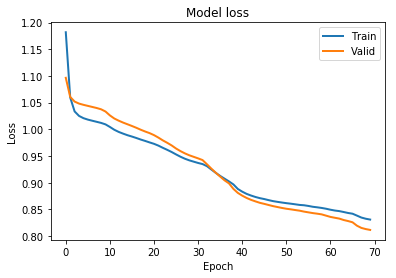

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [17]:
LR = 1e-2

In [18]:
# train the autoencoder
adam = optimizers.Adam(LR)
# model.compile(metrics=['accuracy'], loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/Users/zouhao/Desktop/EEGResearch/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/Users/zouhao/Desktop/EEGResearch/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train_scaled)
print(change.shape)

Train on 1920 samples, validate on 480 samples
Epoch 1/70
 - 19s - loss: 1.0245 - val_loss: 1.0479
Epoch 2/70
 - 19s - loss: 1.0205 - val_loss: 1.0455
Epoch 3/70
 - 19s - loss: 1.0179 - val_loss: 1.0437
Epoch 4/70
 - 22s - loss: 1.0158 - val_loss: 1.0416
Epoch 5/70
 - 20s - loss: 1.0139 - val_loss: 1.0395
Epoch 6/70
 - 22s - loss: 1.0118 - val_loss: 1.0372
Epoch 7/70
 - 25s - loss: 1.0091 - val_loss: 1.0330
Epoch 8/70
 - 20s - loss: 1.0043 - val_loss: 1.0257
Epoch 9/70
 - 19s - loss: 0.9989 - val_loss: 1.0201
Epoch 10/70
 - 20s - loss: 0.9950 - val_loss: 1.0159
Epoch 11/70
 - 20s - loss: 0.9917 - val_loss: 1.0124
Epoch 12/70
 - 20s - loss: 0.9889 - val_loss: 1.0092
Epoch 13/70
 - 21s - loss: 0.9862 - val_loss: 1.0057
Epoch 14/70
 - 23s - loss: 0.9831 - val_loss: 1.0018
Epoch 15/70
 - 21s - loss: 0.9800 - val_loss: 0.9977
Epoch 16/70
 - 21s - loss: 0.9773 - val_loss: 0.9941
Epoch 17/70
 - 20s - loss: 0.9742 - val_loss: 0.9901
Epoch 18/70
 - 20s - loss: 0.9709 - val_loss: 0.9856
Epoch 19

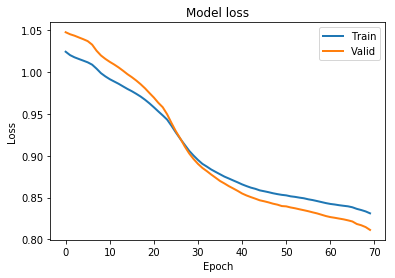

In [20]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Redefine the model in PyTorch

In [21]:
# create tensor and variable
featuresTrain = torch.from_numpy(X_train_scaled)
targetsTrain = torch.from_numpy(y_train).type(torch.LongTensor)

featuresValid = torch.from_numpy(X_valid_scaled)
targetsValid = torch.from_numpy(y_valid).type(torch.LongTensor)

train = TensorDataset(featuresTrain,targetsTrain)
valid = TensorDataset(featuresValid,targetsValid)

In [24]:
# data loader
train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(valid, batch_size = BATCH_SIZE, shuffle = True)

In [88]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                           dropout=0.5, bidirectional=bidirectional)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        encoded_input, hidden = self.lstm(x)  
        encoded_input = self.relu(encoded_input)
        return encoded_input
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, input_size, num_layers, bidirectional):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True,
                            dropout=0.5, bidirectional=bidirectional)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, encoded_input):
        decoded_output, hidden = self.lstm(encoded_input)  
        decoded_output = self.sigmoid(decoded_output)
        return decoded_output
    
class AutoEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=True):
        super(AutoEncoderRNN, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers, bidirectional)
        self.decoder = DecoderRNN(hidden_size, input_size, num_layers, bidirectional)

    def forward(self, x):
        encoded_input = self.encoder(x)
        decoded_output = self.decoder(encoded_input)
        return decoded_output

In [89]:
model = AutoEncoderRNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       num_layers=NUM_LAYERS, 
                       bidirectional=True)
crit = nn.CrossEntropyLoss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR) # optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5) # lr decay

In [105]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.5, bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = Variable(torch.zeros(1, 64, 125))
        x, h = self.lstm(x, h0)
        x = x[:,-1,:].squeeze()
        x = self.linear(x)
        return x

In [106]:
model = LSTMModel(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       num_layers=NUM_LAYERS, 
                       output_size = OUTPUT_SIZE,
                       bidirectional=True)
crit = nn.CrossEntropyLoss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR) # optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5) # lr decay

In [114]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, train_loader, optimizer, crit):
    epoch_loss, epoch_acc = 0., 0.
    model.train()
    total_len = 0.
    # for batch in iterator:
    for step, (data, target) in enumerate(train_loader):
        print(data.shape)
        inputs = data.view(-1, -1, 125)
        print(inputs.shape)
        preds = model(inputs) # squeeze() # [batch_size] # out
        loss = crit(preds, target)
        acc = binary_accuracy(preds, target)
        
        # SGD
        optimizer.zero_grad()
        loss_backward()
        optimizer.step()
        
        epoch_loss += loss_item() * len(target)
        epoch_acc += acc.item() * len(target)
        total_len += len(target)
        
    return epoch_loss / total_len, epoch_acc / total_len

def evaluate(model, test_loader, crit):
    epoch_loss, epoch_acc = 0., 0.
    model.eval()
    total_len = 0.
    for step, (data, target) in enumerate(test_loader):
        preds = model(data) # .squeeze()
        loss = crit(preds, target)
        acc = binary_accuracy(preds, target)
        
        epoch_loss += loss_item() * len(target)
        epoch_acc += acc.item() * len(target)
        total_len += len(target)
    model.train()
        
    return epoch_loss / total_len, epoch_acc / total_len

In [115]:
# training and testing
valid_losses = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, crit)
    valid_loss, valid_acc = evaluate(model, valid_loader, crit)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if i % 1 == 0:
        if len(val_losses) == 0 or valid_loss < min(valid_losses):
            torch.save(model.state_dict(), "/Users/zouhao/Desktop/EEGResearch/lstm_autoencoder_classifier_3.pth")
            print("best model saved to lstm_autoencoder_classifier_3.pth")
        else:
            # lr decay
            scheduler.step()
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        val_losses.append(val_loss)
            
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print("Epoch", epoch, "Train Loss", train_loss, "Train Acc", train_acc)
    print("Epoch", epoch, "Valid_loss", valid_loss, "Valid_acc", valid_acc)

torch.Size([64, 128, 32])


RuntimeError: only one dimension can be inferred

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')

In [ ]:
# test the network
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True)

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)